In [31]:
import numpy as np
import scipy.stats as si

# Black-Scholes formula for European Call and Put options
def black_scholes(S, K, T, r, sigma, option_type='call'):
    # d1 and d2 for Black-Scholes
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        # Call option price
        price = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
        delta = si.norm.cdf(d1, 0.0, 1.0)
    elif option_type == 'put':
        # Put option price
        price = K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0)
        delta = -si.norm.cdf(-d1, 0.0, 1.0)
    
    # Gamma is the same for both calls and puts
    gamma = si.norm.pdf(d1, 0.0, 1.0) / (S * sigma * np.sqrt(T))
    
    return price, delta, gamma

# Given data
S0 = 100          # Initial spot price
K = 100.3         # Strike price
T = 28 / 252     # Time to maturity in years
daily_vol = 0.01  # Daily volatility (1%)
annual_vol = daily_vol * np.sqrt(365)  # Annualized volatility
r = 0.02    # Daily interest rate

# Calculate the price, delta, and gamma for the call and put options
call_price, call_delta, call_gamma = black_scholes(S0, K, T, r, annual_vol, option_type='call')
put_price, put_delta, put_gamma = black_scholes(S0, K, T, r, annual_vol, option_type='put')

# Calculate the portfolio values (short straddle: short call + short put)
straddle_price = -(call_price + put_price)
straddle_delta = -(call_delta + put_delta)
straddle_gamma = -(call_gamma + put_gamma)

# Results for individual options and the global portfolio (straddle)
(call_price, call_delta, call_gamma), (put_price, put_delta, put_gamma), (straddle_price, straddle_delta, straddle_gamma)


((2.5026551080954675, 0.5078582231653578, 0.06263262659603683),
 (2.5800136901817865, -0.4921417768346422, 0.06263262659603683),
 (-5.082668798277254, -0.01571644633071556, -0.12526525319207366))

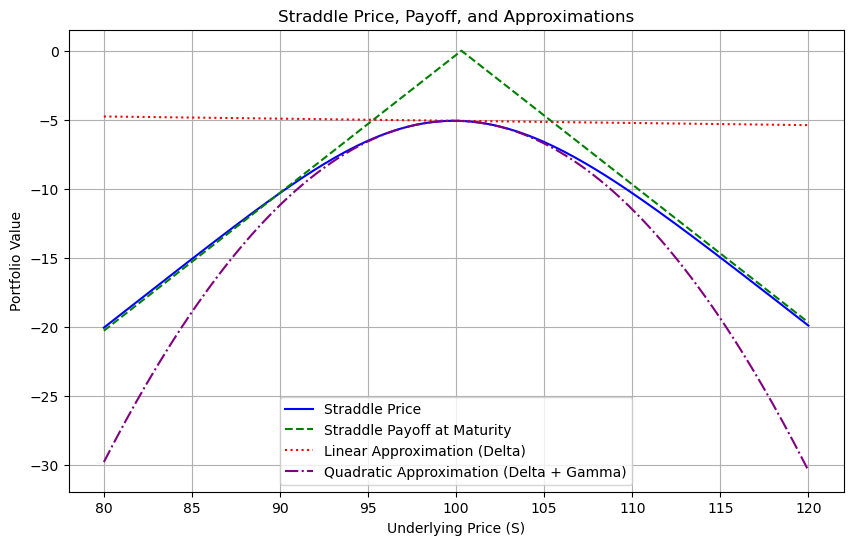

In [32]:
import matplotlib.pyplot as plt

# Define a range of underlying prices for graphing
S_range = np.linspace(80, 120, 200)

# Compute the price and payoff of the portfolio at different underlying prices
call_prices = [black_scholes(S, K, T, r, annual_vol, 'call')[0] for S in S_range]
put_prices = [black_scholes(S, K, T, r, annual_vol, 'put')[0] for S in S_range]
straddle_prices = -(np.array(call_prices) + np.array(put_prices))

# Payoff at maturity for the straddle (short call + short put)
payoff_straddle = -(np.maximum(S_range - K, 0) + np.maximum(K - S_range, 0))

# Linear and Quadratic Approximation
straddle_price_0 = straddle_price
linear_approx = straddle_price_0 + straddle_delta * (S_range - S0)
quadratic_approx = straddle_price_0 + straddle_delta * (S_range - S0) + 0.5 * straddle_gamma * (S_range - S0)**2

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(S_range, straddle_prices, label="Straddle Price", color='blue')
plt.plot(S_range, payoff_straddle, label="Straddle Payoff at Maturity", color='green', linestyle='--')
plt.plot(S_range, linear_approx, label="Linear Approximation (Delta)", color='red', linestyle=':')
plt.plot(S_range, quadratic_approx, label="Quadratic Approximation (Delta + Gamma)", color='purple', linestyle='-.')

plt.title("Straddle Price, Payoff, and Approximations")
plt.xlabel("Underlying Price (S)")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.show()


In [44]:
from scipy.stats import norm

# VaR calculation parameters
confidence_level = 0.99
days = 10
T_10days = days / 252  # 10-day horizon
daily_vol_10days = annual_vol * np.sqrt(10/252)  # Volatility over 10 days

# Delta VaR
VaR_delta = -norm.ppf(confidence_level) * straddle_delta * daily_vol_10days

# Delta-Gamma VaR (accounting for non-linearity)
VaR_delta_gamma = -0.5 * straddle_gamma * (S0 * daily_vol_10days*norm.ppf(confidence_level))**2

VaR_delta, VaR_delta_gamma



(0.0013914742497651243, 4.909556528700401)

In [ ]:
#ONLY USE DELTA GAMMA VAR OR MONTECARLO

In [34]:
# Monte Carlo simulation for 10-day 99% VaR
np.random.seed(42)  # For reproducibility
num_simulations = 10000

# Simulate 10-day price paths using geometric Brownian motion (Gaussian noise)
price_paths = S0 * np.exp((r - 0.5 * annual_vol**2) * T_10days + 
                          annual_vol * np.sqrt(T_10days) * np.random.randn(num_simulations))

# Calculate the portfolio value for each simulated path (straddle price)
simulated_straddle_prices = np.array([
    -(black_scholes(S, K, T - T_10days, r, annual_vol, 'call')[0] + black_scholes(S, K, T - T_10days, r, annual_vol, 'put')[0]) 
    for S in price_paths])

# Calculate the change in portfolio value
portfolio_value_changes = simulated_straddle_prices - straddle_price

# Compute 99% VaR from the distribution of simulated portfolio value changes
VaR_mc_99 = -np.percentile(portfolio_value_changes, (1 - confidence_level) * 100)

VaR_mc_99


5.00799919433845